# 1. Load Data

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datacleaner import autoclean
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
np.random.seed(0) 

In [52]:
salaries = pd.read_csv('data/salaries.csv')
salaries = salaries.sample(frac=0.05, random_state=0)
salaries['income'] = np.where(salaries['income'] == '<=50K', 0, 1)

In [53]:
diabetes = pd.read_csv('data/diabetes.csv')

In [54]:
def exploratory_data_analysis(df):
    """
    Perform exploratory data analysis on a Pandas dataframe.
    """
    print("Shape of dataframe:", df.shape)
    print("\nInformation about the dataframe:")
    print(df.info())
    
    print("\nDescriptive statistics of numerical columns:")
    print(df.describe())
    
    print("\nChecking for missing values:")
    print(df.isnull().sum())
    
    print("\nPlotting histograms for numerical columns:")
    df.hist(bins=30, figsize=(20,20))
    plt.tight_layout()
    plt.show()
    
    print("\nPlotting bar plots for categorical columns:")
    for col in df.columns:
        if df[col].dtype == 'object':
            sns.countplot(x=col, data=df)
            plt.show()

Shape of dataframe: (2442, 15)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2442 entries, 38113 to 2953
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              2442 non-null   int64 
 1   workclass        2442 non-null   object
 2   fnlwgt           2442 non-null   int64 
 3   education        2442 non-null   object
 4   educational-num  2442 non-null   int64 
 5   marital-status   2442 non-null   object
 6   occupation       2442 non-null   object
 7   relationship     2442 non-null   object
 8   race             2442 non-null   object
 9   gender           2442 non-null   object
 10  capital-gain     2442 non-null   int64 
 11  capital-loss     2442 non-null   int64 
 12  hours-per-week   2442 non-null   int64 
 13  native-country   2442 non-null   object
 14  income           2442 non-null   int64 
dtypes: int64(7), object(8)
memory usage: 305.2+ KB
None

D

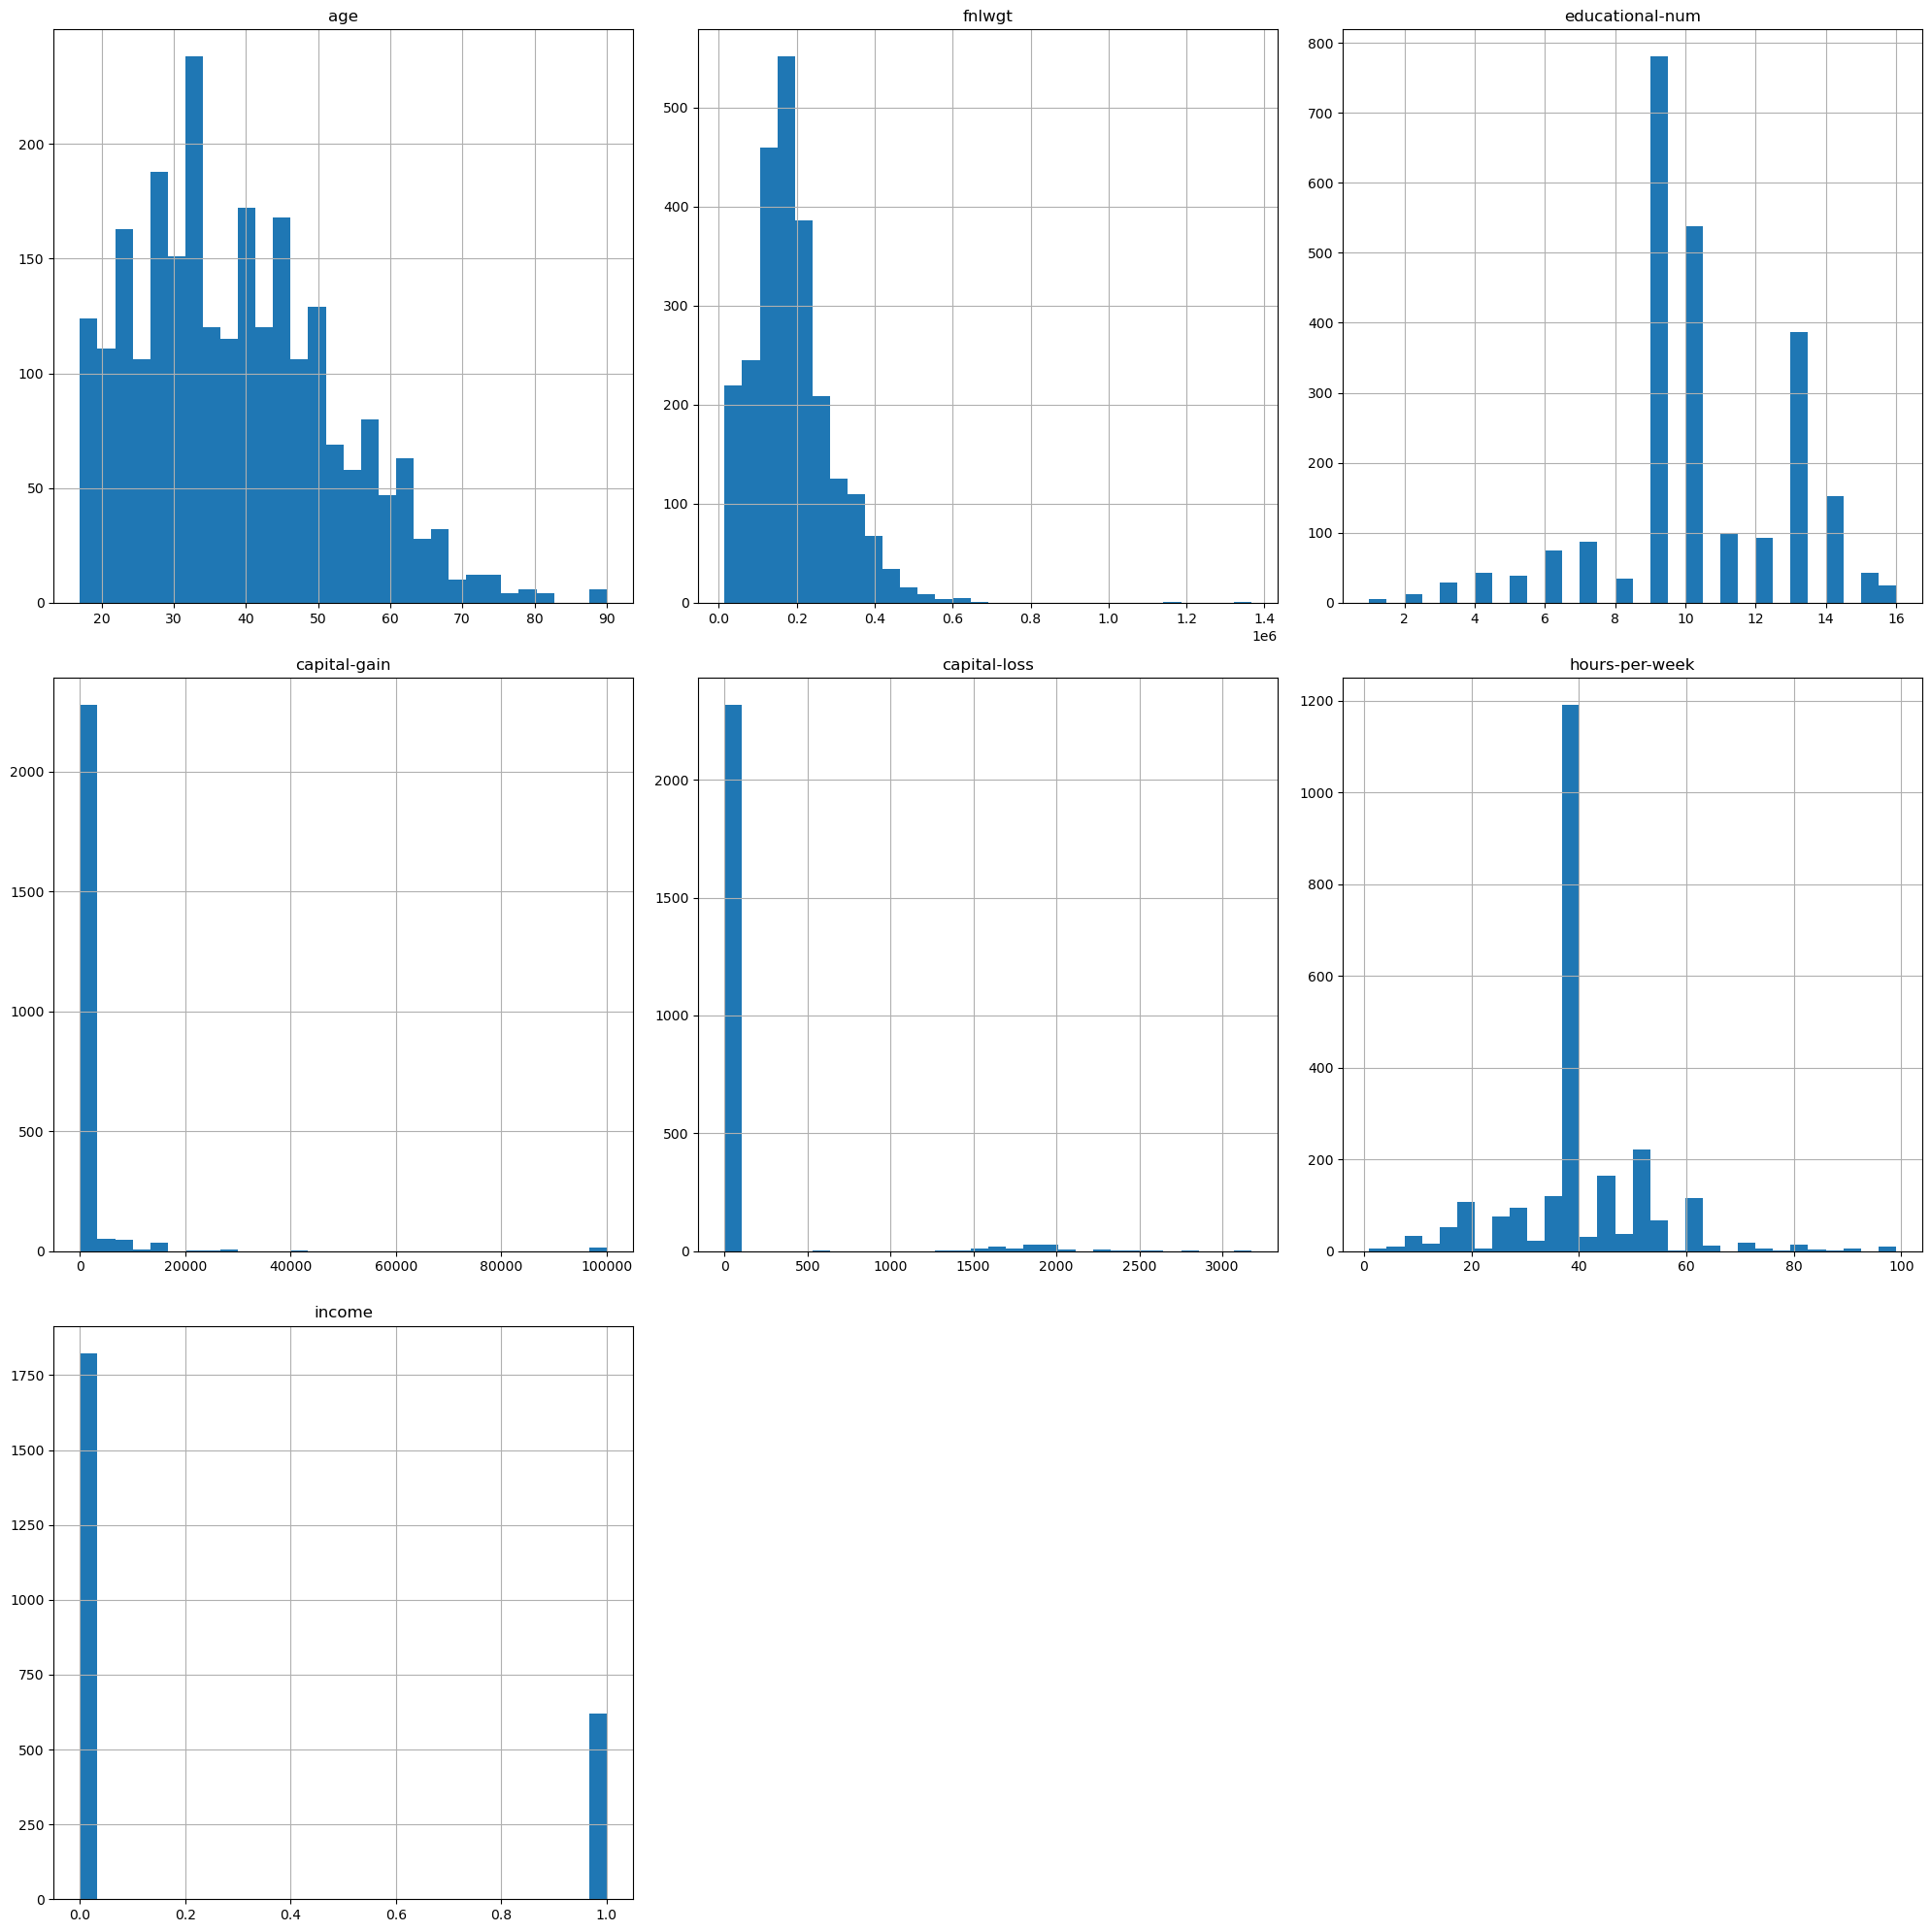


Plotting bar plots for categorical columns:


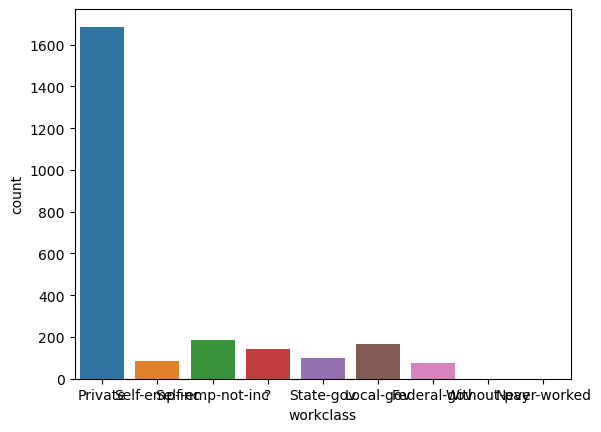

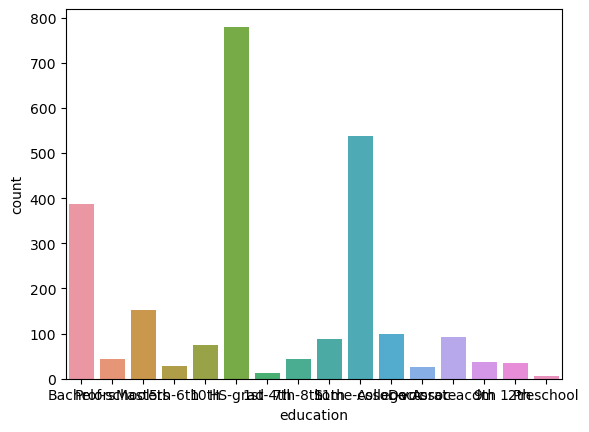

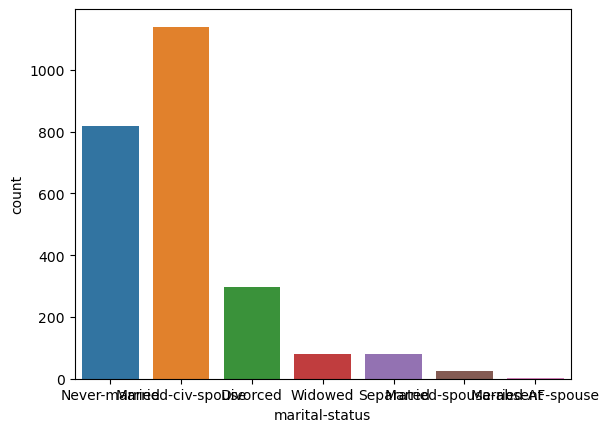

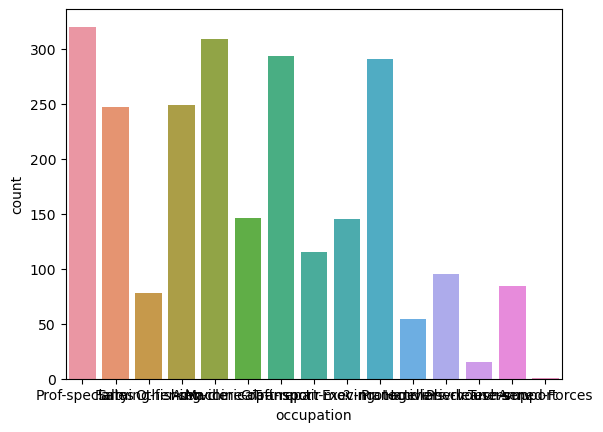

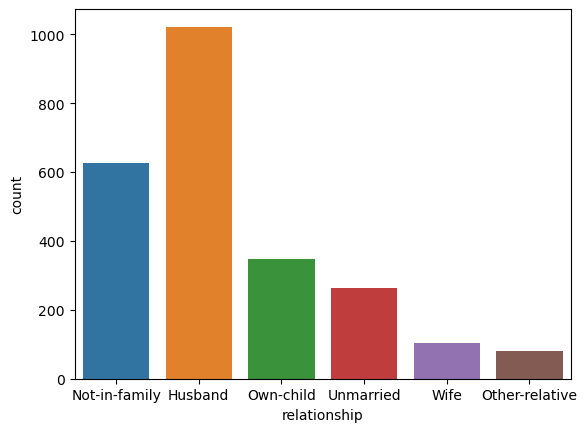

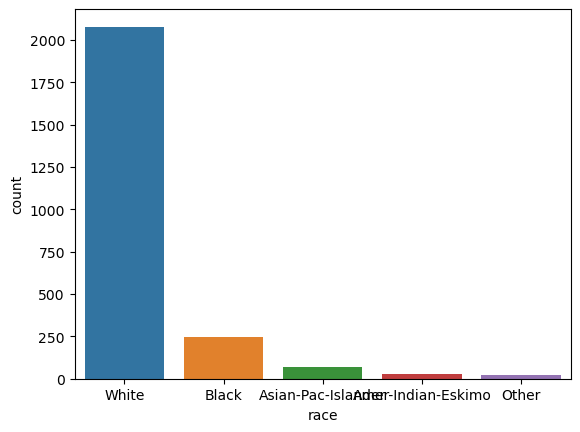

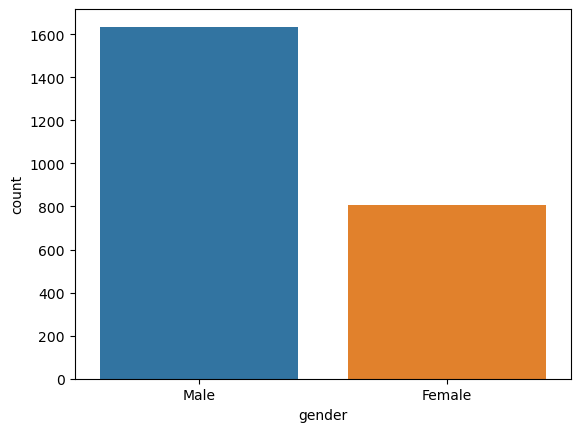

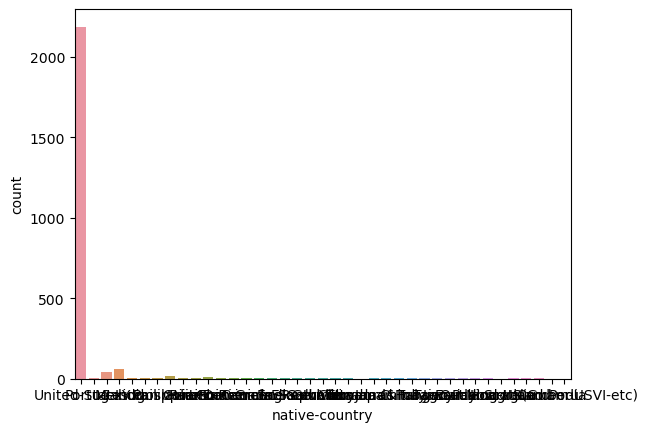

In [55]:
exploratory_data_analysis(salaries)

Shape of dataframe: (768, 9)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Descriptive statistics of numerical columns:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     

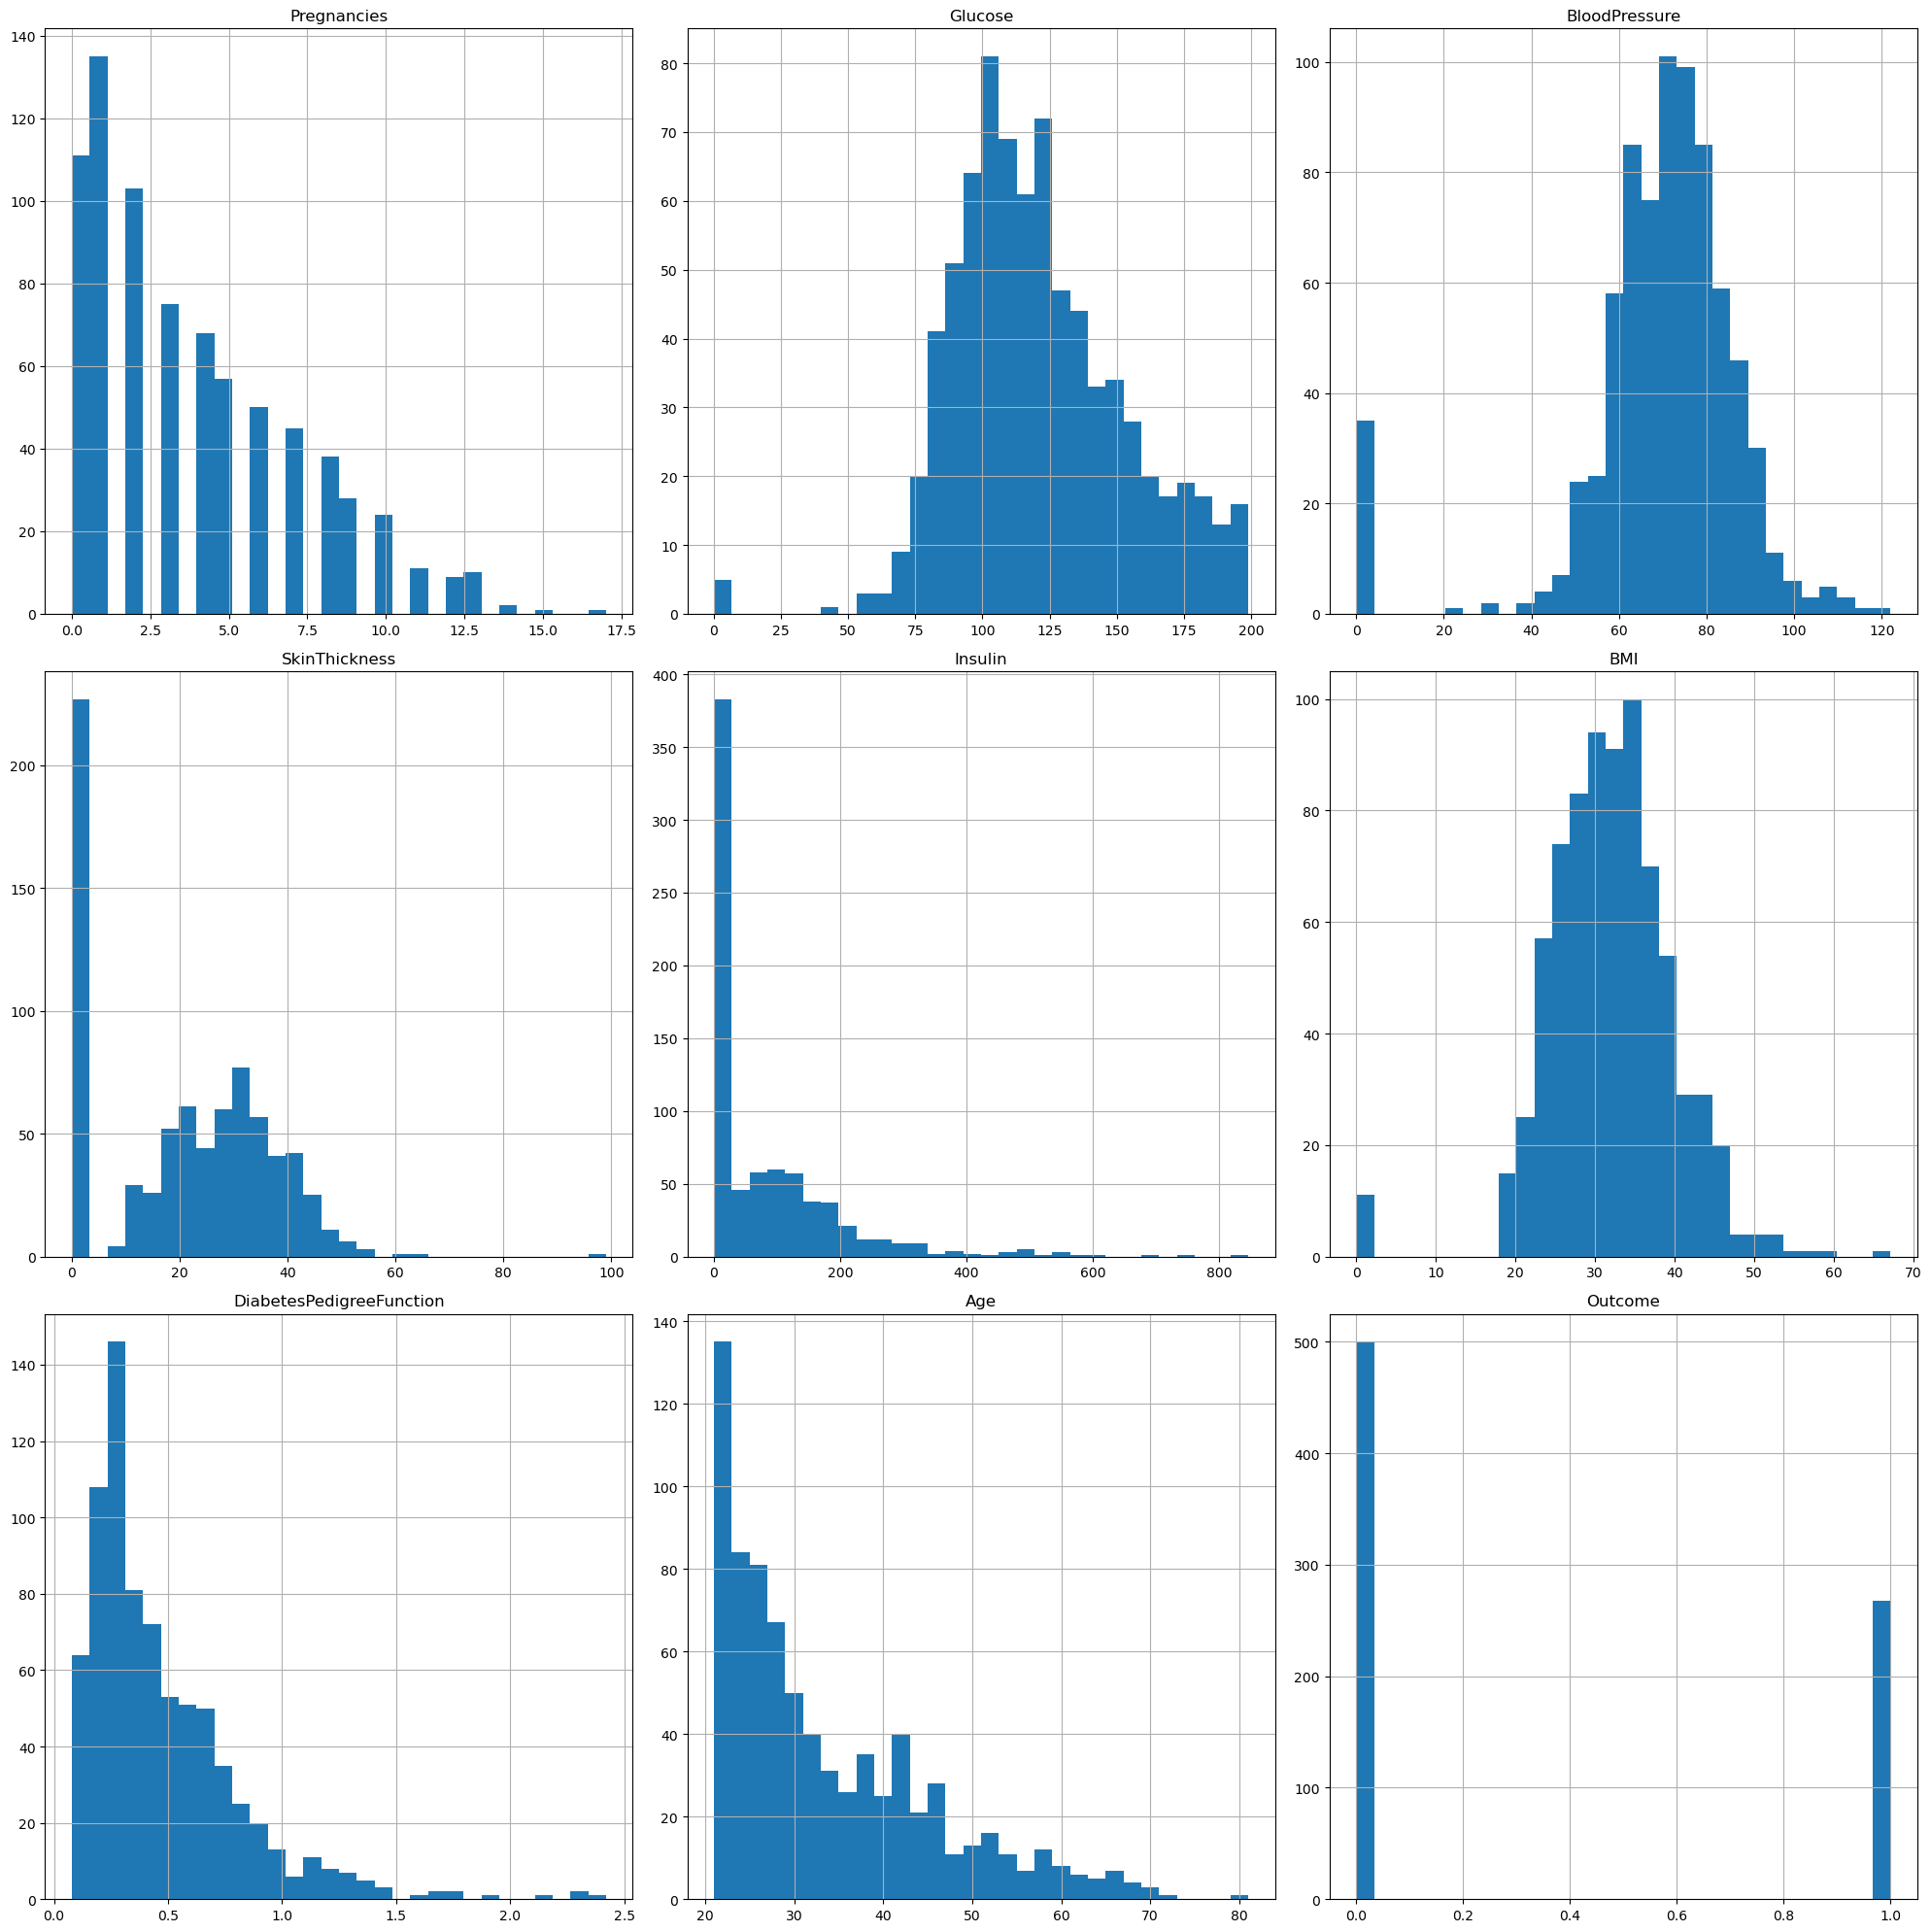


Plotting bar plots for categorical columns:


In [56]:
exploratory_data_analysis(diabetes)

In [57]:
def drop_duplicate_rows(df):
    return df.drop_duplicates(keep='first')

def normalize_features(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

def split_dataset(df, target_col):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
    X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
    y_train, y_test = train_df[target_col], test_df[target_col]
    return X_train, y_train, X_test, y_test

In [58]:
salaries = autoclean(salaries)
salaries = drop_duplicate_rows(salaries)
salaries = normalize_features(salaries)
salaries_X_train, salaries_y_train,  salaries_X_test, salaries_y_test, = split_dataset(salaries, 'income')

In [59]:
diabetes = autoclean(diabetes)
diabetes = drop_duplicate_rows(diabetes)
diabetes = normalize_features(diabetes)
diabetes_X_train, diabetes_y_train,  diabetes_X_test, diabetes_y_test, = split_dataset(diabetes, 'Outcome')

# 3. Utility functions for model evaluation

In [84]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    f1_scorer = make_scorer(f1_score, average='weighted')
    train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    test_scores = cross_val_score(model, X_test, y_test, cv=cv, scoring=f1_scorer)
    return np.mean(train_scores), np.std(train_scores), np.mean(test_scores), np.std(test_scores)

def plot_learning_curve(model, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Testing")
    plt.legend(loc="best")
    plt.show()

def plot_complexity_curve(model, X, y, param_name, param_range, cv=5, n_jobs=-1):
    train_scores, test_scores = validation_curve(model, X, y, param_name=param_name, param_range=param_range, cv=5, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training")
    plt.plot(param_range, test_scores_mean, 'o-', color='orange', label="Testing")
    plt.legend(loc="best")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.show()
    
def optimize_model(model, X_train, y_train, param_grid, cv=5):
    f1_scorer = make_scorer(f1_score, average='weighted')
    grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=cv)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# def compare_models(default_model, optimized_model, X_test, y_test):
#     default_f1_score = f1_score(y_test, default_model.predict(X_test), average='weighted')
#     optimized_f1_score = f1_score(y_test, optimized_model.predict(X_test), average='weighted')
#     print("Default model f1-weighted score:", default_f1_score)
#     print("Optimized model f1-weighted score:", optimized_f1_score)
    
# def get_classification_report(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     report = classification_report(y_test, y_pred, output_dict=True)
#     return report



In [85]:
#model_names = ['dt_salaries', 'dt_diabetes','adaboost_salaries', 'adaboost_diabetes', 'knn_salaries', 'knn_diabetes', 'svc_salaries', 'svc_diabetes','nn_salaries', 'nn_diabetes']
model_fit_times_salaries = []
model_evaluation_times_salaries = []
model_fit_times_diabetes = []
model_evaluation_times_diabetes = []

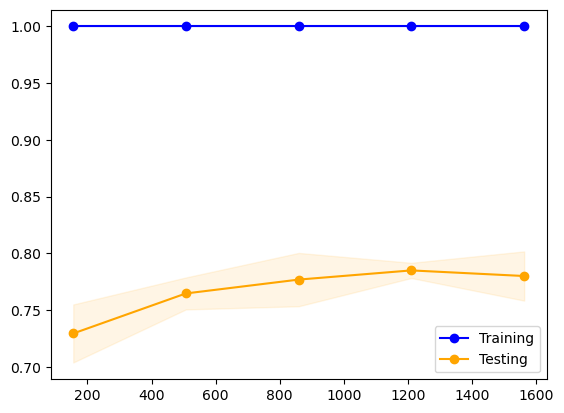

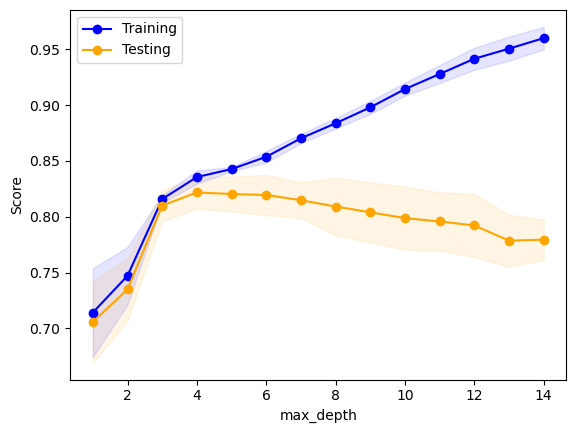

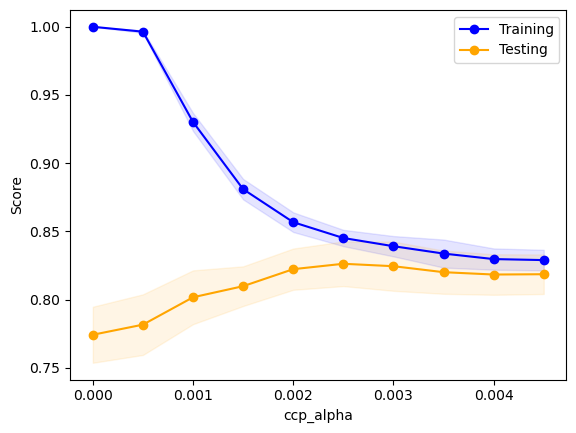

dt best params for salaries
{'ccp_alpha': 0.0025, 'max_depth': 9}


,Model,f1_weighted_score
0,Base Model,0.777677
1,Optimal Model,0.826223


In [86]:
# initialize decision tree model
dtc = DecisionTreeClassifier()
# plot learning curve
plot_learning_curve(dtc, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)


# plot complexity curve
param_name = 'max_depth'
param_range = range(1, 15)
plot_complexity_curve(dtc, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'ccp_alpha'
param_range = np.arange(0.000, 0.005, 0.0005)
plot_complexity_curve(dtc, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)


# use gridsearch cv to identify the best parameters
dt_param_grid = {'max_depth': range(1, 15), 'ccp_alpha': np.arange(0.000, 0.005, 0.0005)}
dt_best_model, dt_best_params = optimize_model(dtc, salaries_X_train, salaries_y_train, dt_param_grid)
start = dt.now()
dt_best_model.fit(salaries_X_train, salaries_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_salaries.append(running_secs)

# evaluate base model and optimal model
dt_base_report = evaluate_model(dtc, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
start = dt.now()
dt_opt_report = evaluate_model(dt_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_salaries.append(running_secs)

# compare f1_weighted score of base model and optimal model
dt_scores = {'Base Model': dt_base_report[0], 'Optimal Model': dt_opt_report[0]}
dt_score_df = pd.DataFrame(list(dt_scores.items()), columns=['Model', 'f1_weighted_score'])

print('dt best params for salaries')
print(dt_best_params)
dt_score_df

#plt.show()

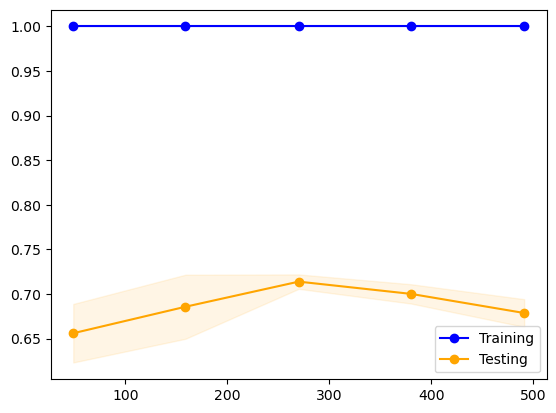

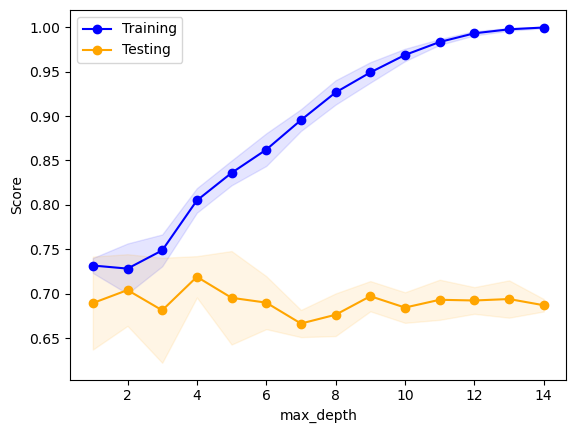

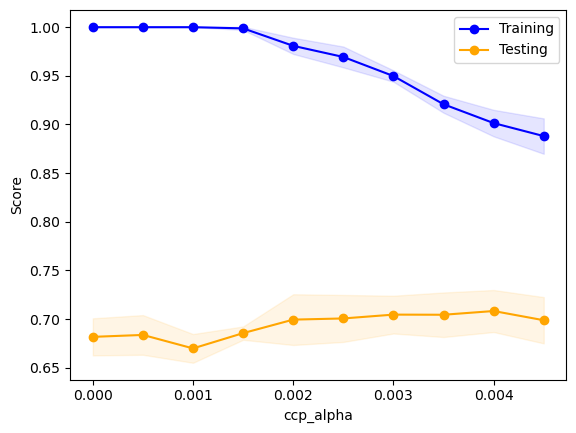

dt best params for diabetes
{'ccp_alpha': 0.004, 'max_depth': 4}


,Model,f1_weighted_score
0,Base Model,0.674484
1,Optimal Model,0.722015


In [87]:
# initialize decision tree model
dtc = DecisionTreeClassifier()
# plot learning curve
plot_learning_curve(dtc, diabetes_X_train, diabetes_y_train, cv=5, n_jobs=-1)


# plot complexity curve
param_name = 'max_depth'
param_range = range(1, 15)
plot_complexity_curve(dtc, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'ccp_alpha'
param_range = np.arange(0.000, 0.005, 0.0005)
plot_complexity_curve(dtc, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)


# use gridsearch cv to identify the best parameters
dt_param_grid = {'max_depth': range(1, 15), 'ccp_alpha': np.arange(0.000, 0.005, 0.0005)}
dt_best_model, dt_best_params = optimize_model(dtc, diabetes_X_train, diabetes_y_train, dt_param_grid)
start = dt.now()
dt_best_model.fit(diabetes_X_train, diabetes_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_diabetes.append(running_secs)

# evaluate base model and optimal model
dt_base_report = evaluate_model(dtc, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
start = dt.now()
dt_opt_report = evaluate_model(dt_best_model, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test, cv=5)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_diabetes.append(running_secs)

# compare f1_weighted score of base model and optimal model
dt_scores = {'Base Model': dt_base_report[0], 'Optimal Model': dt_opt_report[0]}
dt_score_df = pd.DataFrame(list(dt_scores.items()), columns=['Model', 'f1_weighted_score'])

print('dt best params for diabetes')
print(dt_best_params)
dt_score_df

#plt.show()

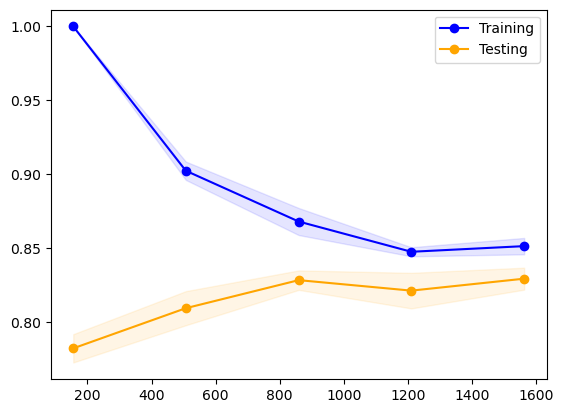

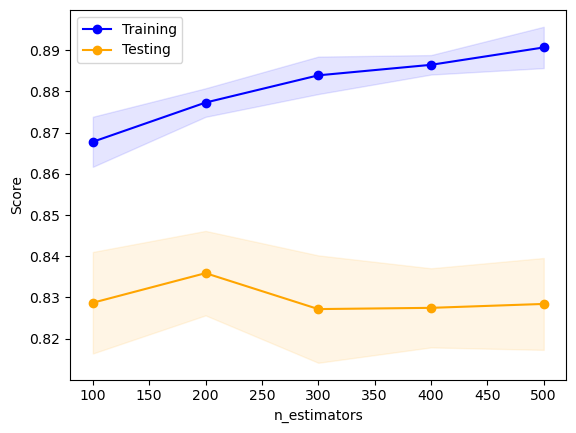

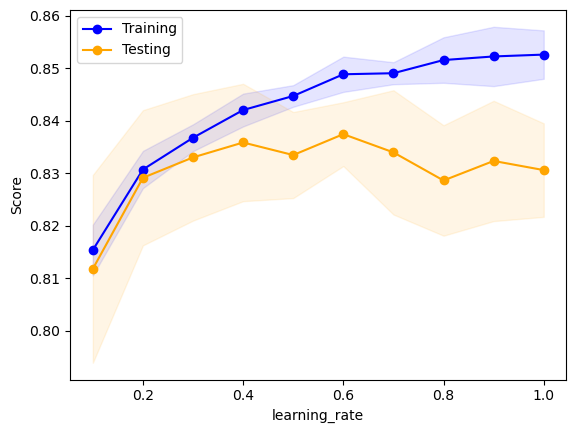

ada best params for salaries
{'learning_rate': 0.30000000000000004, 'n_estimators': 300}


,Model,f1_weighted_score
0,Base Model,0.830597
1,Optimal Model,0.841857


In [88]:
#initialize Adaboost model
ada = AdaBoostClassifier()
plot_learning_curve(ada, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'n_estimators'
param_range = range(100, 600, 100)
plot_complexity_curve(ada, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'learning_rate'
param_range = np.arange(0.1, 1.1, 0.1)
plot_complexity_curve(ada, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)


ada_param_grid = {'n_estimators':  range(100, 600, 100), 'learning_rate': np.arange(0.1, 1.1, 0.1)}
ada_best_model, ada_best_params = optimize_model(ada, salaries_X_train, salaries_y_train, ada_param_grid)
start = dt.now()
ada_best_model.fit(salaries_X_train, salaries_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_salaries.append(running_secs)


ada_base_report = evaluate_model(ada, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
start = dt.now()
ada_opt_report = evaluate_model(ada_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_salaries.append(running_secs)


ada_scores = {'Base Model': ada_base_report[0], 'Optimal Model': ada_opt_report[0]}
ada_score_df = pd.DataFrame(list(ada_scores.items()), columns=['Model', 'f1_weighted_score'])

print('ada best params for salaries')
print(ada_best_params)

ada_score_df

#plt.show()

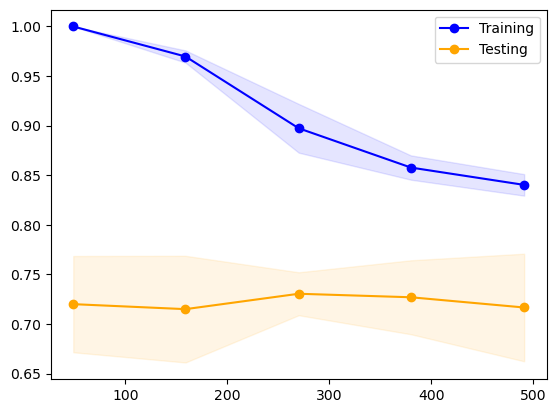

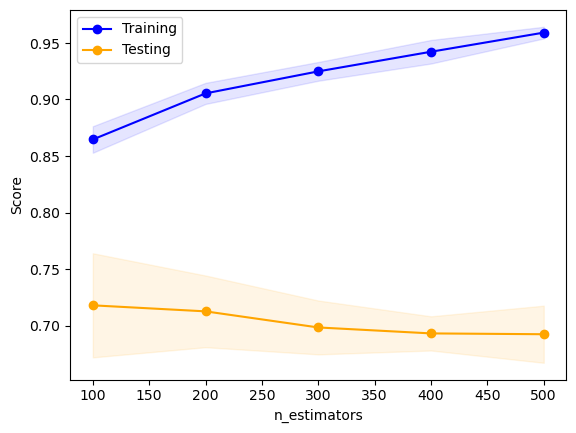

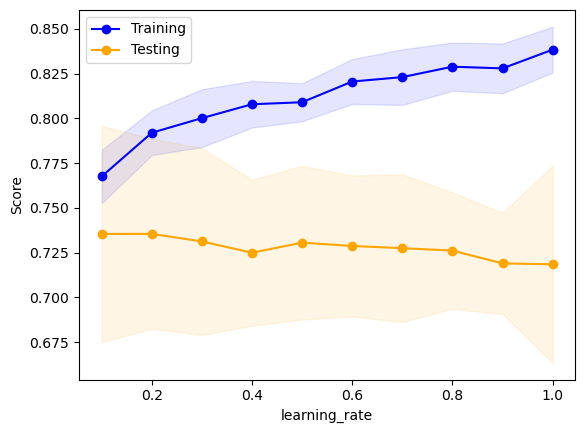

ada best params for diabetes
{'learning_rate': 0.1, 'n_estimators': 100}


,Model,f1_weighted_score
0,Base Model,0.718539
1,Optimal Model,0.742241


In [89]:
#initialize Adaboost model
ada = AdaBoostClassifier()
plot_learning_curve(ada, diabetes_X_train, diabetes_y_train, cv=5, n_jobs=-1)

param_name = 'n_estimators'
param_range = range(100, 600, 100)
plot_complexity_curve(ada, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'learning_rate'
param_range = np.arange(0.1, 1.1, 0.1)
plot_complexity_curve(ada, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)


ada_param_grid = {'n_estimators':  range(100, 600, 100), 'learning_rate': np.arange(0.1, 1.1, 0.1)}
ada_best_model, ada_best_params = optimize_model(ada, diabetes_X_train, diabetes_y_train, ada_param_grid)
start = dt.now()
ada_best_model.fit(diabetes_X_train, diabetes_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_diabetes.append(running_secs)


ada_base_report = evaluate_model(ada, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
start = dt.now()
ada_opt_report = evaluate_model(ada_best_model, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_diabetes.append(running_secs)



ada_scores = {'Base Model': ada_base_report[0], 'Optimal Model': ada_opt_report[0]}
ada_score_df = pd.DataFrame(list(ada_scores.items()), columns=['Model', 'f1_weighted_score'])

print('ada best params for diabetes')
print(ada_best_params)

ada_score_df

#plt.show()

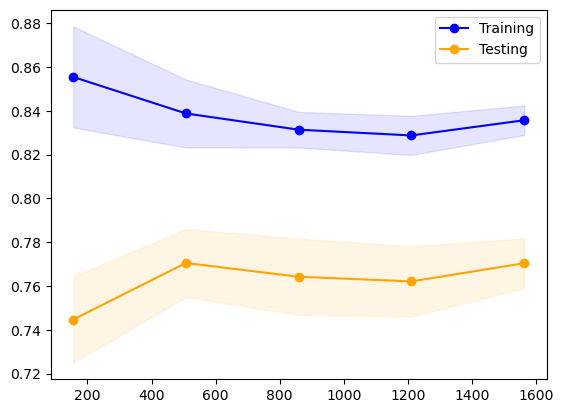

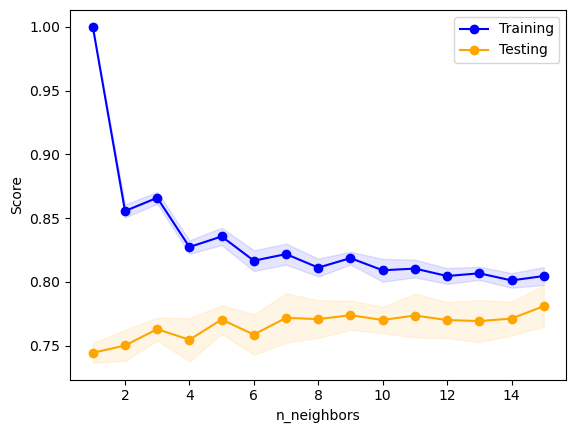

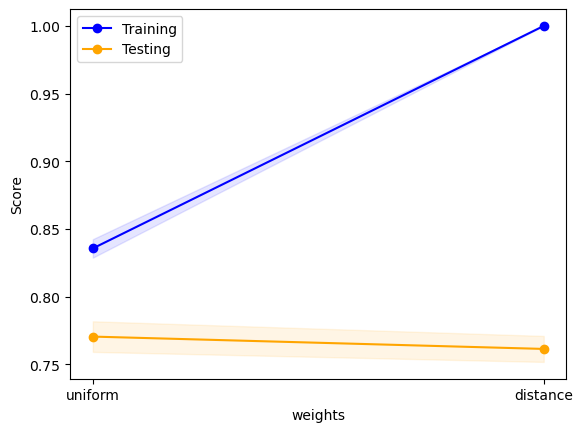

knn best params for salaries
{'n_neighbors': 15, 'weights': 'uniform'}


,Model,f1_weighted_score
0,Base Model,0.770381
1,Optimal Model,0.780874


In [90]:
knn = KNeighborsClassifier()
plot_learning_curve(knn, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'n_neighbors'
param_range = range(1, 16)
plot_complexity_curve(knn, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'weights'
param_range = ['uniform', 'distance']
plot_complexity_curve(knn, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

knn_param_grid = {'n_neighbors': range(1, 16), 'weights': ['uniform', 'distance']}
knn_best_model, knn_best_params = optimize_model(knn, salaries_X_train, salaries_y_train, knn_param_grid)
start = dt.now()
knn_best_model.fit(salaries_X_train, salaries_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_salaries.append(running_secs)

knn_base_report = evaluate_model(knn, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
start = dt.now()
knn_opt_report = evaluate_model(knn_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_salaries.append(running_secs)


knn_scores = {'Base Model': knn_base_report[0], 'Optimal Model': knn_opt_report[0]}
knn_score_df = pd.DataFrame(list(knn_scores.items()), columns=['Model', 'f1_weighted_score'])

print('knn best params for salaries')
print(knn_best_params)

knn_score_df

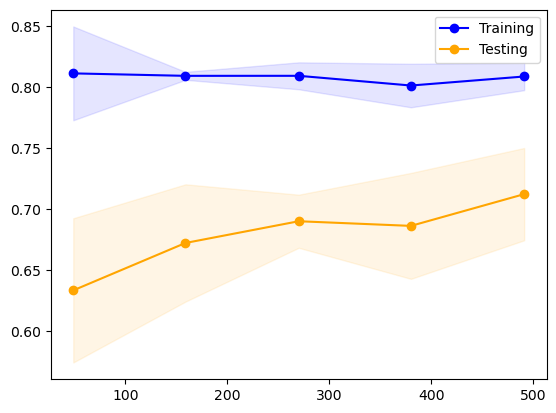

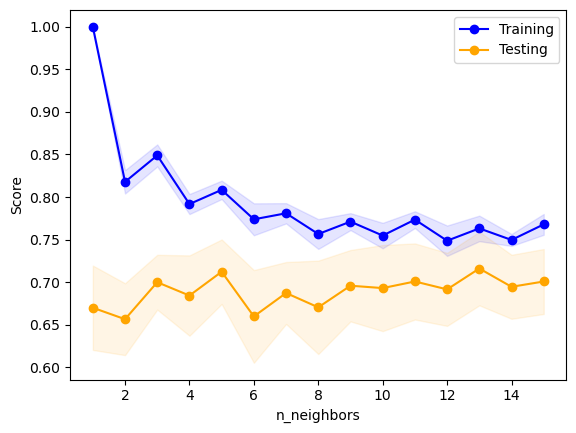

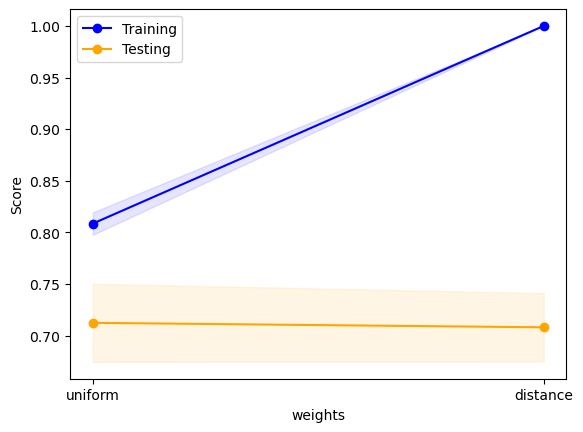

knn best params for diabetes
{'n_neighbors': 13, 'weights': 'distance'}


,Model,f1_weighted_score
0,Base Model,0.712296
1,Optimal Model,0.721149


In [91]:
knn = KNeighborsClassifier()
plot_learning_curve(knn, diabetes_X_train, diabetes_y_train, cv=5, n_jobs=-1)

param_name = 'n_neighbors'
param_range = range(1, 16)
plot_complexity_curve(knn, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'weights'
param_range = ['uniform', 'distance']
plot_complexity_curve(knn, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

knn_param_grid = {'n_neighbors': range(1, 16), 'weights': ['uniform', 'distance']}
knn_best_model, knn_best_params = optimize_model(knn, diabetes_X_train, diabetes_y_train, knn_param_grid)
start = dt.now()
knn_best_model.fit(diabetes_X_train, diabetes_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_diabetes.append(running_secs)

knn_base_report = evaluate_model(knn, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
start = dt.now()
knn_opt_report = evaluate_model(knn_best_model, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_diabetes.append(running_secs)

knn_scores = {'Base Model': knn_base_report[0], 'Optimal Model': knn_opt_report[0]}
knn_score_df = pd.DataFrame(list(knn_scores.items()), columns=['Model', 'f1_weighted_score'])

print('knn best params for diabetes')
print(knn_best_params)

knn_score_df

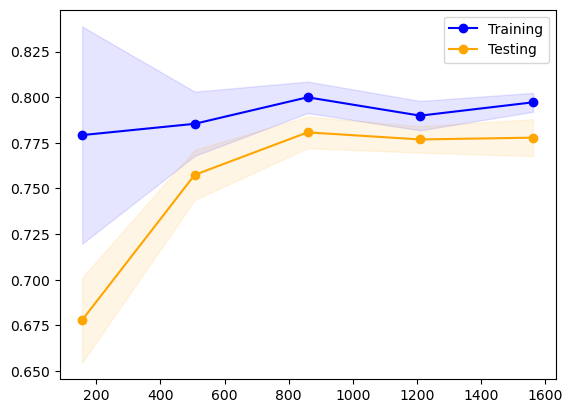

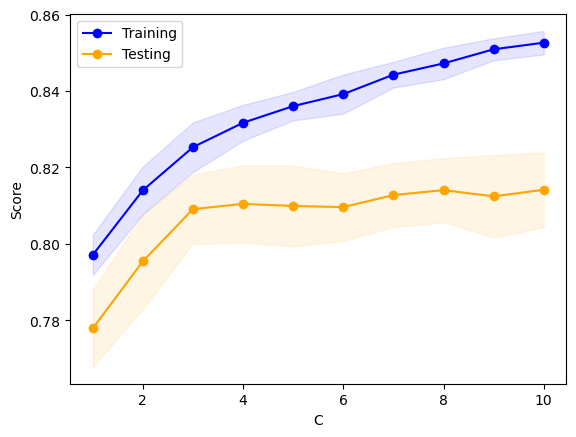

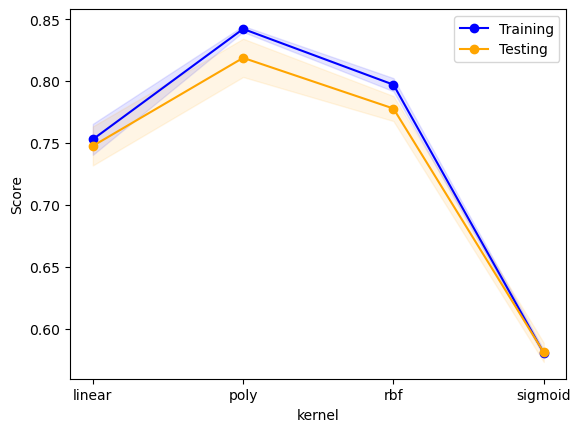

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 220.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 315, in _dense_fit
    

svc best params for salaries
{'C': 4, 'kernel': 'poly'}


,Model,f1_weighted_score
0,Base Model,0.777866
1,Optimal Model,0.825481


In [92]:
svc = SVC()
plot_learning_curve(svc, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'C'
param_range = np.arange(0, 11, 1)
plot_complexity_curve(svc, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'kernel'
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
plot_complexity_curve(svc, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

svc_param_grid = {'C': np.arange(0, 11, 1), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_best_model, svc_best_params = optimize_model(svc, salaries_X_train, salaries_y_train, svc_param_grid)
start = dt.now()
svc_best_model.fit(salaries_X_train, salaries_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_salaries.append(running_secs)

svc_base_report = evaluate_model(svc, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
start = dt.now()
svc_opt_report = evaluate_model(svc_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_salaries.append(running_secs)

svc_scores = {'Base Model': svc_base_report[0], 'Optimal Model': svc_opt_report[0]}
svc_score_df = pd.DataFrame(list(svc_scores.items()), columns=['Model', 'f1_weighted_score'])

print('svc best params for salaries')
print(svc_best_params)

svc_score_df

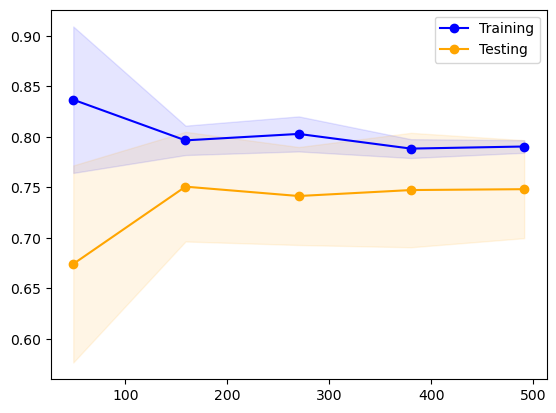

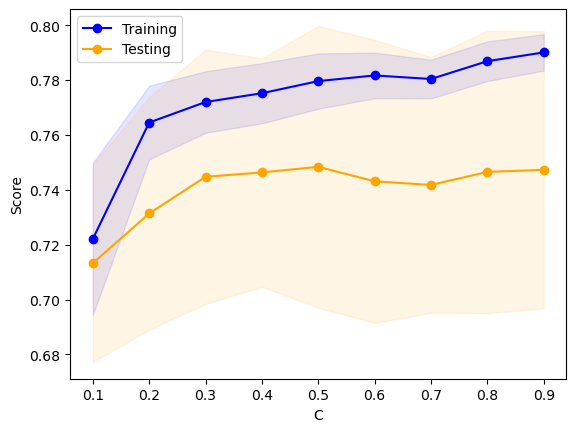

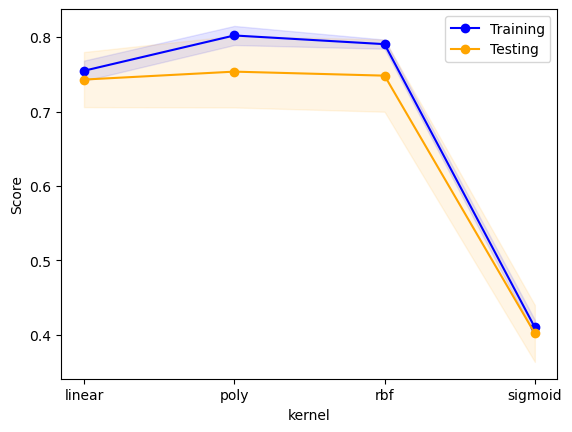

svc best params for diabetes
{'C': 0.6000000000000001, 'kernel': 'poly'}


/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 315, in _dense_fit
    

,Model,f1_weighted_score
0,Base Model,0.748214
1,Optimal Model,0.761373


In [93]:
svc = SVC()
plot_learning_curve(svc, diabetes_X_train, diabetes_y_train, cv=5, n_jobs=-1)

param_name = 'C'
param_range = np.arange(0, 1, 0.1)
plot_complexity_curve(svc, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'kernel'
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
plot_complexity_curve(svc, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

svc_param_grid = {'C': np.arange(0, 1, 0.1), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_best_model, svc_best_params = optimize_model(svc, diabetes_X_train, diabetes_y_train, svc_param_grid)
start = dt.now()
svc_best_model.fit(diabetes_X_train, diabetes_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_diabetes.append(running_secs)

svc_base_report = evaluate_model(svc, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
start = dt.now()
svc_opt_report = evaluate_model(svc_best_model, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_diabetes.append(running_secs)

svc_scores = {'Base Model': svc_base_report[0], 'Optimal Model': svc_opt_report[0]}
svc_score_df = pd.DataFrame(list(svc_scores.items()), columns=['Model', 'f1_weighted_score'])

print('svc best params for diabetes')
print(svc_best_params)

svc_score_df

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

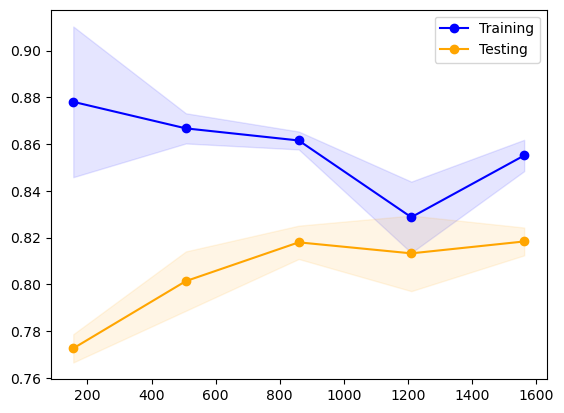

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

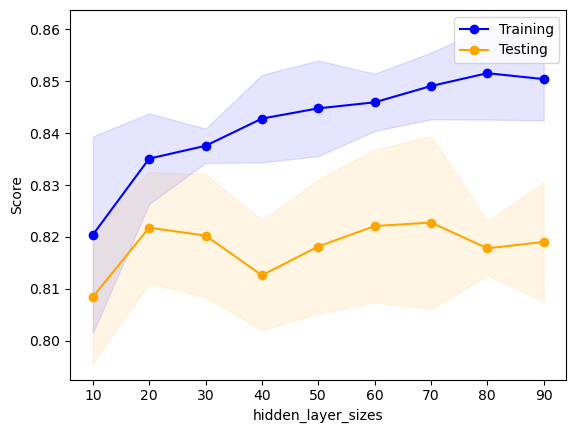

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

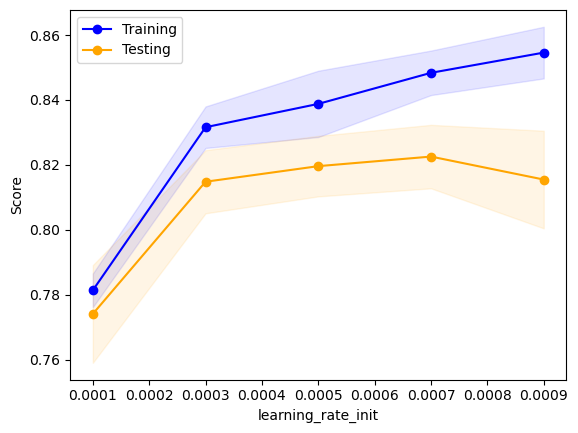

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

mlp best params for salaries
{'hidden_layer_sizes': 60, 'learning_rate_init': 0.0005000000000000001}


/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,f1_weighted_score
0,Base Model,0.819313
1,Optimal Model,0.819967


In [94]:
mlp = MLPClassifier(max_iter = 500, alpha = 0.0005)
plot_learning_curve(mlp, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'hidden_layer_sizes'
param_range = range(10, 100, 10)
plot_complexity_curve(mlp, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'learning_rate_init'
param_range = np.arange(0.0001, 0.001, 0.0002)
plot_complexity_curve(mlp, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

mlp_param_grid = {'hidden_layer_sizes': range(10, 100, 10),
'learning_rate_init': np.arange(0.0001, 0.001, 0.0002)}
mlp_best_model, mlp_best_params = optimize_model(mlp, salaries_X_train, salaries_y_train, mlp_param_grid)
start = dt.now()
mlp_best_model.fit(salaries_X_train, salaries_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_salaries.append(running_secs)

mlp_base_report = evaluate_model(mlp, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
start = dt.now()
mlp_opt_report = evaluate_model(mlp_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_salaries.append(running_secs)

mlp_scores = {'Base Model': mlp_base_report[0], 'Optimal Model': mlp_opt_report[0]}
mlp_score_df = pd.DataFrame(list(mlp_scores.items()), columns=['Model', 'f1_weighted_score'])

print('mlp best params for salaries')
print(mlp_best_params)

mlp_score_df

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

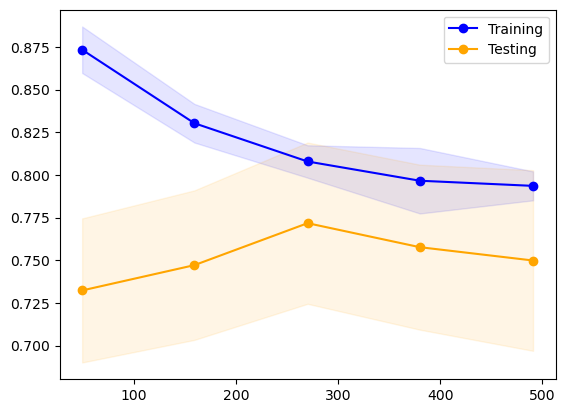

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

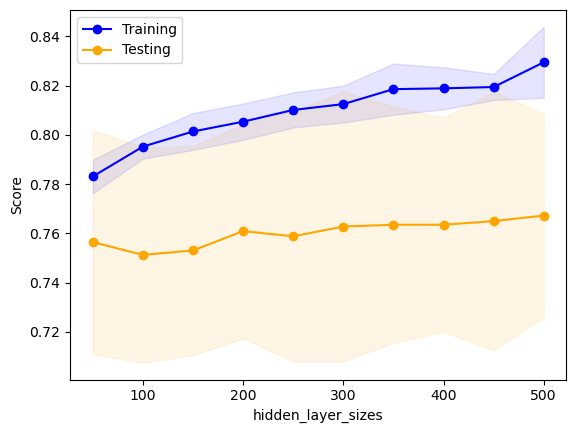

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

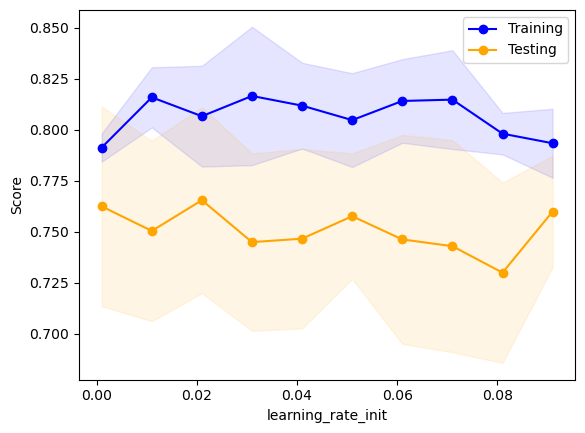

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/louis/opt/anacond

mlp best params for diabetes
{'hidden_layer_sizes': 250, 'learning_rate_init': 0.040999999999999995}


/Users/louis/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,f1_weighted_score
0,Base Model,0.765002
1,Optimal Model,0.743110


In [95]:
mlp = MLPClassifier(max_iter = 500)
plot_learning_curve(mlp, diabetes_X_train, diabetes_y_train, cv=5, n_jobs=-1)

param_name = 'hidden_layer_sizes'
param_range = range(50, 550, 50)
plot_complexity_curve(mlp, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'learning_rate_init'
param_range = np.arange(0.001, 0.1, 0.01)
plot_complexity_curve(mlp, diabetes_X_train, diabetes_y_train, param_name, param_range, cv=5, n_jobs=-1)

mlp_param_grid = {'hidden_layer_sizes': range(50, 550, 50),
'learning_rate_init': np.arange(0.001, 0.1, 0.01)}
mlp_best_model, mlp_best_params = optimize_model(mlp, diabetes_X_train, diabetes_y_train, mlp_param_grid)
start = dt.now()
mlp_best_model.fit(diabetes_X_train, diabetes_y_train)
running_secs = (dt.now() - start).microseconds
model_fit_times_diabetes.append(running_secs)

mlp_base_report = evaluate_model(mlp, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
start = dt.now()
mlp_opt_report = evaluate_model(mlp_best_model, diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test)
running_secs = (dt.now() - start).microseconds
model_evaluation_times_diabetes.append(running_secs)

mlp_scores = {'Base Model': mlp_base_report[0], 'Optimal Model': mlp_opt_report[0]}
mlp_score_df = pd.DataFrame(list(mlp_scores.items()), columns=['Model', 'f1_weighted_score'])

print('mlp best params for diabetes')
print(mlp_best_params)

mlp_score_df

In [96]:
model_names = ['dt','adaboost', 'knn', 'svc','nn']
# model_fit_times_salaries = []
# model_evaluation_times_salaries = []
# model_fit_times_diabetes = []
# model_evaluation_times_diabetes = []
clock_times_df = pd.DataFrame({'model_names': model_names, 'fit_times_salary': model_fit_times_salaries, 'evaluation_times_salary': model_evaluation_times_salaries, 'fit_times_diabetes': model_fit_times_diabetes, 'evaluation_times_diabetes': model_evaluation_times_diabetes })


In [99]:
clock_times_df

,model_names,fit_times_salary,evaluation_times_salary,fit_times_diabetes,evaluation_times_diabetes
0,dt,4668,42477,1468,23262
1,adaboost,398822,83066,86285,784428
2,knn,1765,103160,797,27369
3,svc,117887,425365,11996,63077
4,nn,471847,753879,124501,919315


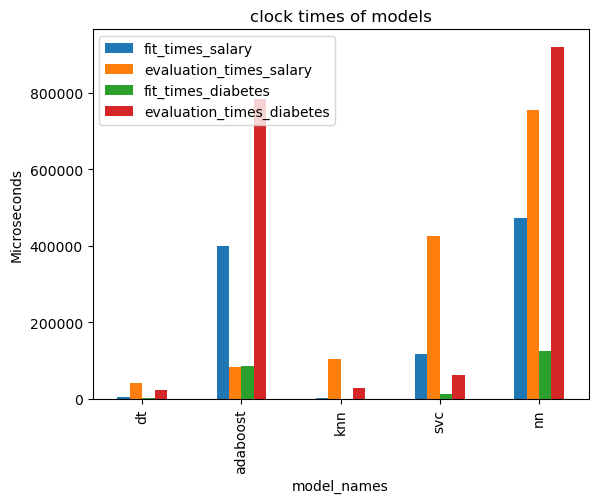

In [107]:
clock_times_df.set_index('model_names').plot.bar()
plt.title('Bar Plot of DataFrame')
plt.ylabel('Microseconds')
plt.title('clock times of models')

# show the plot
plt.show()